In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import torch
import time
from tqdm.autonotebook import tqdm
from scipy import signal
import time
%matplotlib inline
import pickle

In [2]:
from cUtils import *
from tmpUtils import *
from Rfuns import bw_nrd0_R

In [3]:
dataPath = Path("../data")

### Load the Amat from real data

In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [5]:
realPath = dataPath/"realmat.pkl"
if realPath.exists():
    with open(realPath, "rb") as f:
        real = pickle.load(f)
else:
    datF = list(dataPath.glob("*.mat"))[0]
    rawDat = loadmat(datF)
    dat = rawDat["DK_timecourse"]
    fs = 600
    q = 50
    nDat = mat2Tensor(dat, fs=fs, q=q)
    bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
    downrates = [1, 1]
    hs = [0.1, 0.1]
    T = 60
    _, dF, dT = nDat.Y.shape
    times = np.linspace(0, T, dT)
    freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
    Amat = GetAmatTorch(torch.tensor(nDat.Y.copy()), torch.tensor(nDat.X.copy()), times, freqs, downrates, hs)
    
    res = np.linalg.eig(Amat)
    absEigVs = np.abs(res[0])
    # Sort the eigvs and vectors such that the vals is in order
    sortIdx = np.argsort(absEigVs)[::-1]
    lams = res[0][sortIdx]
    U = res[1][:, sortIdx]
    
    real = edict()
    real["Amat"] = Amat
    real["U"] = U
    real["eigVs"] = lams
    real["X"] = nDat.X
    real["Y"] = nDat.Y
    
    with open(realPath, "wb") as f:
        pickle.dump(real, f)

In [6]:
R = 6
dF = 5
dT = 100
invU = np.linalg.inv(real.U)
pUinv = torch.tensor(invU[:R, :])
rawX = torch.tensor(real.X[:, :dF, :dT]) # d x dF x dT
pRawX = rawX.permute(1, 2, 0).type_as(pUinv) # dF x dT x d
X = pRawX.matmul(pUinv.T) # dF x dT x R

In [31]:
ChgsFreq = [1]
ChgsT = [25]
eigIndAll = real.eigVs.imag != 0
ChgsTF = np.concatenate([[0], ChgsT, [dT]])
ChgsFreqF = np.concatenate([[0], ChgsFreq, [dF]])

In [32]:
Mus = GenFVecs(R, eigIndAll[:R], ChgsFreqF)
Nus = GenFVecs(R, eigIndAll[:R], ChgsTF)
stdMus =  Mus /np.linalg.norm(Mus, axis=1).reshape(-1, 1)

In [33]:
Y = torch.zeros_like(X)
for df in range(dF):
    for dt in range(dT):
        cX = X[df, dt, :]
        cMu = stdMus[:, df]
        cNu = Nus[:, dt]
        pEigVs = torch.tensor(cMu * cNu)
        cY = cX * pEigVs + 0*torch.randn(R)
        Y[df, dt, :] = cY

In [144]:
outIterC =  5e-9
lams = [8e1, 5e1]
# lams = [8e1, 5e1] # good para for fixed truth
iterNums = [200, 200]
betas = [1, 1]
iterCs = [1e-8, 1e-8]
As = [2.7, 2.7]
alps = [0.9, 0.9]

In [225]:
R2 = 2*R
tNus = np.concatenate([Nus.real, Nus.imag])
tMus = np.concatenate([stdMus.real, stdMus.imag])
paraNuInit = torch.tensor(tNus) + torch.randn(R2, dT)/10
paraNuInit = torch.randn(R2, dT)

paraMuInit = torch.tensor(tMus) + torch.randn(R2, dF)/10
paraMuInit = torch.randn(R2, dF)
norm2 = torch.norm(paraMuInit, dim=1)**2
newNorm = torch.sqrt(norm2[:R] + norm2[R:])
newNorm = torch.cat([newNorm, newNorm])
paraMuInitStd = paraMuInit/newNorm.reshape(-1, 1)

rho1 = torch.ones(R2*(dF-1))
rho2 = torch.ones(R2*(dT-1))
rhos = [rho1, rho2]

In [226]:
maxIter = 10
showSubProg = True
penalty = "GroupLasso"
chDiffBoth = torch.tensor(1e10) # Stopping rule
        
lastMuTheta = DiffMatOpt(colStackFn(paraMuInitStd), R2) # R2x(dF-1)
fixedNuMat = paraNuInit
fixedNuMatC = torch.complex(fixedNuMat[:R, :], fixedNuMat[R:, :]).type_as(pUinv) # complex number, R x dT 

stopLastMuMat = paraMuInitStd
stopLastNuMat = paraNuInit
        
pbar = tqdm(range(maxIter))
for i in pbar:
    if i == 0:
        pbar.set_description(f"Outer Loop: The chdiff is {chDiffBoth.item():.3e}.")
    else:
        pbar.set_description(f"Outer Loop:"
                             f"{chDiffMu.item():.3e}, "
                             f"{chDiffNu.item():.3e}, "
                             f"{chDiffBoth.item():.3e}.")
    optMu = OneStepOpt(X=rawX, Y=Y, pUinv=pUinv, fixedParas=fixedNuMat, lastTheta=lastMuTheta, penalty=penalty,
                       alp=alps[0], beta=betas[0], lam=lams[0], 
                       a=As[0], iterNum=iterNums[0], rho=rhos[0], iterC=iterCs[0])
    
    # fixedNuMatC = torch.tensor(Nus)
    muY = Y * (1/fixedNuMatC.T)
    optMu.NewXr = X.real
    optMu.NewXi = X.imag
    optMu.NewYr = muY.real
    optMu.NewYi = muY.imag
    optMu(showSubProg)
    
    fixedMuMat = optMu.GamMatStd
    fixedMuMatC = torch.complex(fixedMuMat[:R, :], fixedMuMat[R:, :]).type_as(pUinv) # complex number, R x dT 
    
    if i == 0:
        lastNuTheta = DiffMatOpt(colStackFn(fixedNuMat), R2)
    else:
        lastNuTheta = optNu.lastTheta
    
    optNu = OneStepOpt(X=rawX, Y=Y, pUinv=pUinv, fixedParas=fixedMuMat, lastTheta=lastNuTheta, penalty=penalty,
                       alp=alps[1], beta=betas[1], lam=lams[1], 
                       a=As[1], iterNum=iterNums[1], rho=rhos[1], iterC=iterCs[1])
    # fixedMuMatC = torch.tensor(stdMus)
    nuY = Y * (1/fixedMuMatC.T).unsqueeze(1)
    optNu.NewXr = X.real
    optNu.NewXi = X.imag
    optNu.NewYr = nuY.real
    optNu.NewYi = nuY.imag
    optNu(showSubProg)
    
    fixedNuMat = optNu.GamMat
    # lastMuTheta = DiffMatOpt(optMu.newVecGamStd, R2)
    lastMuTheta = optMu.lastThetaStd
    #rhos = [optMu.rho, optNu.rho]
    
    chDiffMu = torch.norm(stopLastMuMat-fixedMuMat)/torch.norm(stopLastMuMat)
    chDiffNu = torch.norm(stopLastNuMat-fixedNuMat)/torch.norm(stopLastNuMat)
    chDiffBoth = torch.max(chDiffMu,chDiffNu)
    
    stopLastMuMat = fixedMuMat
    stopLastNuMat = fixedNuMat
    
    if chDiffBoth <= outIterC:
        break

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [227]:
eMus = optMu.GamMatStd.cpu().numpy()
eThetas = optMu.ThetaMatStd.cpu().numpy()
tMus = np.concatenate([stdMus.real, stdMus.imag])
eDiffMus = np.diff(eMus)

([], [])

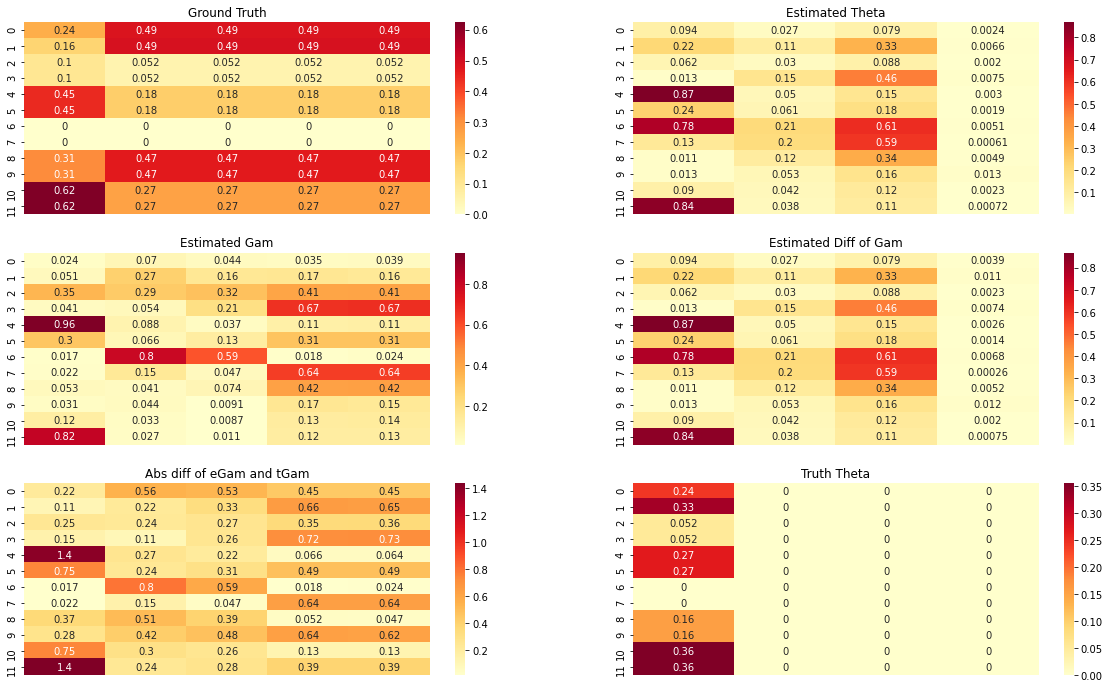

In [228]:
plt.figure(figsize=[20, 12])

is_annot = True
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(325)
plt.title("Abs diff of eGam and tGam")
sns.heatmap(np.abs(tMus-eMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(322)
plt.title("Estimated Theta")
sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tMus)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

In [223]:
eNus = optNu.GamMat.cpu().numpy()
eThetas = optNu.ThetaMat.cpu().numpy()
tNus = np.concatenate([Nus.real, Nus.imag])
eDiffNus = np.diff(eNus)

([], [])

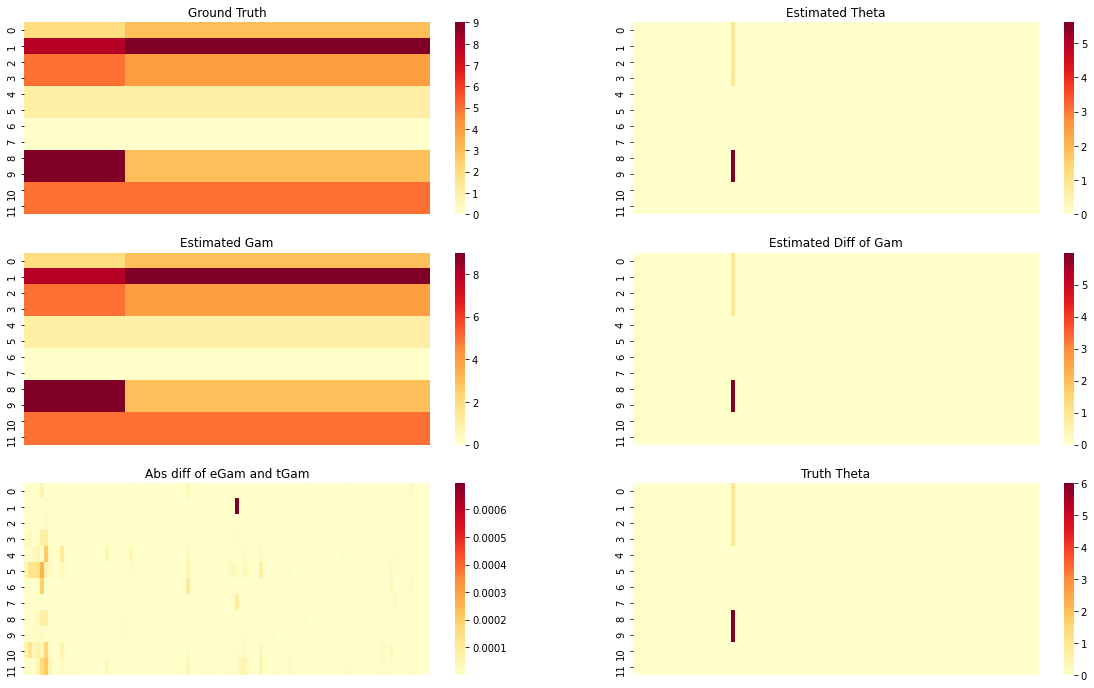

In [224]:
plt.figure(figsize=[20, 12])

is_annot = False
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(325)
plt.title("Abs diff of eGam and tGam")
sns.heatmap(np.abs(tNus-eNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(322)
plt.title("Estimated Theta")
sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tNus)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

### Error 

In [229]:
eNusC = np.zeros_like(Nus)
eNusC.real = eNus[:R, :]
eNusC.imag = eNus[R:, :]
eMusC = np.zeros_like(Mus)
eMusC.real = eMus[:R, :]
eMusC.imag = eMus[R:, :]

eY = torch.zeros_like(X)
for df in range(dF):
    for dt in range(dT):
        cX = X[df, dt, :]
        cMu = eMusC[:, df]
        cNu = eNusC[:, dt]
        pEigVs = torch.tensor(cMu * cNu)
        cY = cX * pEigVs + 0*torch.randn(R)
        eY[df, dt, :] = cY

In [230]:
torch.norm(eY - Y)

tensor(136407.3343)